# Visão geral do projeto

- Trabalharemos com dois datasets: `df` (2,5 milhões de registros) e `test` (100 registros nos quais rotulei manualmente).
  - Depois de criar e validar o modelo com os dados de `test`, iremos aplicá-lo em `df` para rotular os três milhões de registros.
- Primeiro vamos preparar o dataset com o objetivo de criar e manter apenas os dados relevantes para a **análise**.
- Depois, faremos o pré-processamento dos dados. Aqui estamos preparando os dados para o **modelo**.
- Após os dados estarem prontos, partiremos para a modelagem.
  - Além de construir o modelo, também validaremos e otimizaremos sua performance.
- Por fim, os dados já estarão rotulados com um score de sentimento, e então os analisaremos.

# Importando pacotes iniciais e Datasets

In [1]:
import re
#import spacy
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
import optuna

from spellchecker import SpellChecker

import pyarrow as pa  
import pyarrow.parquet as pq  

In [2]:
df = pd.read_parquet('df_train.parquet', engine='pyarrow')

In [3]:
test = pd.read_parquet('df_test.parquet', engine='pyarrow')

In [4]:
df = df[:2500000]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 116.8+ MB


# Transformação dos Dados

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 116.8+ MB


- 'in_response_to_tweet_id' e 'tweet_id' estão como variáveis numéricas. Vamos usá-las como string futuramente. 

In [7]:
df['in_response_to_tweet_id'] = df['in_response_to_tweet_id'].astype('Int64').astype('object')
df['tweet_id'] = df['tweet_id'].astype(str)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 7 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   tweet_id                 object
 1   author_id                object
 2   inbound                  bool  
 3   created_at               object
 4   text                     object
 5   response_tweet_id        object
 6   in_response_to_tweet_id  object
dtypes: bool(1), object(6)
memory usage: 116.8+ MB


In [9]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,None,1
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6


## Criando a coluna 'empresa_id'

- Quero criar uma coluna que indique a qual empresa cada tweet se refere.

- Vamos começar identificando as menções às empresas na variável `text`.

Obs: O objetivo dessas mudanças é facilitar futuras análises, e os dados de teste não serão incluídos. Por isso, essas alterações serão feitas apenas em `df`.

In [10]:
# Separando os ids/nomes das empresas
empresas_ids = df[df['inbound'] == False]['author_id'].unique()

In [11]:
empresas_ids

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps',
       'ATVIAssist', 'AdobeCare', 'AmazonHelp', 'XboxSupport',
       'AirbnbHelp', 'nationalrailenq', 'AirAsiaSupport', 'Morrisons',
       'NikeSupport', 'AskAmex', 'McDonalds', 'YahooCare', 'AskLyft',
       'UPSHelp', 'Delta', 'AppleSupport', 'Uber_Support', 'Tesco',
       'SpotifyCares', 'British_Airways', 'comcastcares', 'AmericanAir',
       'TMobileHelp', 'VirginTrains', 'SouthwestAir', 'AskeBay',
       'hulu_support', 'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport',
       'ChaseSupport', 'CoxHelp', 'DropboxSupport', 'VirginAtlantic',
       'BofA_Help', 'AzureSupport', 'AlaskaAir', 'ArgosHelpers',
       'Postmates_Help', 'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp',
       'AskPapaJohns', 'SW_Help', 'askpanera', 'Walmart',
       'USCellularCares', 'AsurionCares', 'GloCare', 'idea_cares',
       'DoorDash_Help', 'NeweggService', 'VirginA

In [12]:
# Identificando as empresas com base em menções no texto
def identificar_empresa_por_mencao(row, empresas_ids):
    if row['inbound'] == True: 
        for empresa_id in empresas_ids:
            if f"@{empresa_id}" in row['text']:  
                return empresa_id
        return None

df['empresa_id'] = df.apply(identificar_empresa_por_mencao, axis=1, args=(empresas_ids,))

In [13]:
# Vamos ver como ficou
df[df['inbound'] == True].head(50)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,empresa_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,None,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6,sprintcare
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",<NA>,sprintcare
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15,sprintcare
10,16,115713,True,Tue Oct 31 20:00:43 +0000 2017,@sprintcare Since I signed up with you....Sinc...,15,17,sprintcare
12,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,<NA>,None
14,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,<NA>,None
16,22,115716,True,Tue Oct 31 22:16:48 +0000 2017,@Ask_Spectrum Would you like me to email you a...,25,21,Ask_Spectrum
18,26,115716,True,Tue Oct 31 22:19:56 +0000 2017,@Ask_Spectrum I received this from your corpor...,27,25,Ask_Spectrum


In [14]:
# Conferindo quantos ainda estão nulos
df[df['inbound'] == True]['empresa_id'].isna().sum()

342922

- Alguns clientes ainda não estão sendo rotulados. O motivo é que são tweets onde eles não mencionam diretamente a empresa.

- Irei utilizar tanto a coluna `in_response_to_tweet_id` quanto a coluna `response_tweet_id` para rotular os clientes que ainda não foram identificados.

In [15]:
def identificar_empresa_eficiente(df, empresas_ids):
    # Criar dicionários para consulta rápida
    tweet_id_to_author = df.dropna(subset=['tweet_id']).set_index('tweet_id')['author_id'].to_dict()
    
    # Convertendo empresas_ids para set. Isso permite uma busca mais rápida.
    empresas_set = set(empresas_ids)
    
    # Processar em lotes
    def process_row(row):
        # Se já tem empresa_id definido ou não é inbound, retorna o existente
        if not pd.isna(row['empresa_id']) or row['inbound'] != True:
            return row['empresa_id']
        
        # Verificar in_response_to_tweet_id
        if pd.notnull(row['in_response_to_tweet_id']):
            author = tweet_id_to_author.get(row['in_response_to_tweet_id'])
            if author in empresas_set:
                return author
        
        # Verificar response_tweet_id
        if pd.notnull(row['response_tweet_id']):
            author = tweet_id_to_author.get(row['response_tweet_id'])
            if author in empresas_set:
                return author
        
        return None
    
    return df.apply(process_row, axis=1)

df['empresa_id'] = identificar_empresa_eficiente(df, empresas_ids)

In [16]:
df[df['inbound'] == True]['empresa_id'].isna().sum()

80546

In [17]:
df[df['inbound'] == True].head(50)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,empresa_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,None,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6,sprintcare
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",<NA>,sprintcare
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15,sprintcare
10,16,115713,True,Tue Oct 31 20:00:43 +0000 2017,@sprintcare Since I signed up with you....Sinc...,15,17,sprintcare
12,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,<NA>,sprintcare
14,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,<NA>,sprintcare
16,22,115716,True,Tue Oct 31 22:16:48 +0000 2017,@Ask_Spectrum Would you like me to email you a...,25,21,Ask_Spectrum
18,26,115716,True,Tue Oct 31 22:19:56 +0000 2017,@Ask_Spectrum I received this from your corpor...,27,25,Ask_Spectrum


- Com isso, uma pequena minoria de clientes ainda estão sem rótulo. Me parece ser aqueles que estão respondendo e interagindo com outros clientes. 

- Para resolver isso, primeiro irei excluir os tweets das empresas: 

`df = df[df['inbound'] == True]`

 - E depois, preciso preencher os valores de 'empresa_id' que estão nulos, com o valor de 'empresa_id' da linha anterior.
    - Estou fazendo isso, pois ao observar os dados, percebi que os valores de 'empresa_id' faltantes são sequência do mesmo assunto de tweets anteriores (sendo o meio ou final de um assunto).
    - Isso só é possível porque as funções anteriores já rotularam grande parte dos tweets e os tweets estão ordenados.


In [18]:
# Excluindo os tweets das empresas
df = df[df['inbound'] == True]

In [19]:
# Preenchendo os valores nulos
df['empresa_id'] = df['empresa_id'].ffill()

In [20]:
df.head(50)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,empresa_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,None,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6,sprintcare
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",<NA>,sprintcare
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15,sprintcare
10,16,115713,True,Tue Oct 31 20:00:43 +0000 2017,@sprintcare Since I signed up with you....Sinc...,15,17,sprintcare
12,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,<NA>,sprintcare
14,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,<NA>,sprintcare
16,22,115716,True,Tue Oct 31 22:16:48 +0000 2017,@Ask_Spectrum Would you like me to email you a...,25,21,Ask_Spectrum
18,26,115716,True,Tue Oct 31 22:19:56 +0000 2017,@Ask_Spectrum I received this from your corpor...,27,25,Ask_Spectrum


In [21]:
df['empresa_id'].isna().sum()

0

- Agora todos os dados estão rotulados. 
- Vamos excluir as variáveis que não serão utilizadas.

In [22]:
df.drop(['tweet_id', 'author_id', 'inbound', 'response_tweet_id', 'in_response_to_tweet_id'],
         axis=1, inplace=True)

In [23]:
df.head()

,created_at,text,empresa_id
1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,sprintcare
2,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,sprintcare
4,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,sprintcare
6,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare
8,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,sprintcare


## Excluindo registros com poucos exemplos

- Como mencionei, no final do projeto faremos uma análise rápida sobre o que os dados nos revelam.

- Uma das análises será voltada para as empresas com as melhores e piores avaliações.

    - Por isso, é fundamental excluir as empresas com um baixo número de tweets, ou seja, um volume pequeno de amostras.

In [24]:
df.head()

,created_at,text,empresa_id
1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,sprintcare
2,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,sprintcare
4,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,sprintcare
6,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare
8,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,sprintcare


In [25]:
df['empresa_id'].value_counts()

empresa_id
AmazonHelp         178215
AppleSupport       120576
Uber_Support        62903
AmericanAir         43819
SpotifyCares        42791
                    ...  
mediatemplehelp       263
CarlsJr               244
OfficeSupport         241
AskDSC                222
HotelTonightCX        170
Name: count, Length: 108, dtype: int64

In [26]:
empresas_contagem = df['empresa_id'].value_counts()

In [27]:
# Buscando o nome das empresas com mais de 1000 avaliações
empresas = [empresa for empresa in empresas_contagem.index if empresas_contagem[empresa] >= 1000]

# Selecionando as empresas no dataset
df = df[df['empresa_id'].isin(empresas)]

df['empresa_id'].value_counts()

empresa_id
AmazonHelp         178215
AppleSupport       120576
Uber_Support        62903
AmericanAir         43819
SpotifyCares        42791
                    ...  
YahooCare            1144
NeweggService        1138
BoostCare            1114
OPPOCareIN           1043
GooglePlayMusic      1038
Name: count, Length: 92, dtype: int64

## Coluna 'created_at'

- Agora vamos fragmentar 'created_at' em quatro novas variáveis: ano, mês, dia da semana, dia do mês e hora.

In [28]:
# Mudando o tipo de dado
df['created_at'] = pd.to_datetime(
    df['created_at'], 
    format='%a %b %d %H:%M:%S %z %Y',  # Formato específico
    errors='coerce'  
)

In [29]:
# Criando as novas variáveis
df['ano'] = df['created_at'].dt.year
df['mes'] = df['created_at'].dt.month_name()
df['dia_semana'] = df['created_at'].dt.day_name()
df['dia_mes'] = df['created_at'].dt.day
df['horario'] = df['created_at'].dt.hour

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1357527 entries, 1 to 2499998
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   created_at  1357527 non-null  datetime64[ns, UTC]
 1   text        1357527 non-null  object             
 2   empresa_id  1357527 non-null  object             
 3   ano         1357527 non-null  int32              
 4   mes         1357527 non-null  object             
 5   dia_semana  1357527 non-null  object             
 6   dia_mes     1357527 non-null  int32              
 7   horario     1357527 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(3), object(4)
memory usage: 77.7+ MB


In [31]:
df.head(50)

,created_at,text,empresa_id,ano,mes,dia_semana,dia_mes,horario
1,2017-10-31 22:11:45+00:00,@sprintcare and how do you propose we do that,sprintcare,2017,October,Tuesday,31,22
2,2017-10-31 22:08:27+00:00,@sprintcare I have sent several private messag...,sprintcare,2017,October,Tuesday,31,22
4,2017-10-31 21:49:35+00:00,@sprintcare I did.,sprintcare,2017,October,Tuesday,31,21
6,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,2017,October,Tuesday,31,21
8,2017-10-31 22:04:47+00:00,@sprintcare You gonna magically change your co...,sprintcare,2017,October,Tuesday,31,22
10,2017-10-31 20:00:43+00:00,@sprintcare Since I signed up with you....Sinc...,sprintcare,2017,October,Tuesday,31,20
12,2017-10-31 19:56:01+00:00,@115714 y’all lie about your “great” connectio...,sprintcare,2017,October,Tuesday,31,19
14,2017-10-31 22:03:34+00:00,"@115714 whenever I contact customer support, t...",sprintcare,2017,October,Tuesday,31,22
16,2017-10-31 22:16:48+00:00,@Ask_Spectrum Would you like me to email you a...,Ask_Spectrum,2017,October,Tuesday,31,22
18,2017-10-31 22:19:56+00:00,@Ask_Spectrum I received this from your corpor...,Ask_Spectrum,2017,October,Tuesday,31,22


- As variáveis podem estar bem desbalanceadas, principalmente mês e ano que são as mais abrangentes.
-  Vamos dar uma olhada nelas.

In [32]:
for col in ['ano', 'mes', 'dia_semana', 'dia_mes', 'horario']:
    print('-'*30)
    if col in ['ano', 'mes']:
        print(f'\nValores únicos de "{col}": {df[col].unique()}')
    print(f'\nContagem de cada valor de "{col}": {df[col].value_counts()}')
    print('-'*30)

------------------------------

Valores únicos de "ano": [2017 2011 2016 2014 2015 2013 2012 2008 2010]

Contagem de cada valor de "ano": ano
2017    1356273
2016        856
2015        220
2014         93
2013         40
2012         34
2011          7
2010          3
2008          1
Name: count, dtype: int64
------------------------------
------------------------------

Valores únicos de "mes": ['October' 'November' 'December' 'August' 'September' 'March' 'May'
 'February' 'July' 'June' 'April' 'January']

Contagem de cada valor de "mes": mes
October      668595
November     603878
December      74661
September      6690
August         1299
July            659
June            432
May             358
April           296
February        223
January         220
March           216
Name: count, dtype: int64
------------------------------
------------------------------

Contagem de cada valor de "dia_semana": dia_semana
Friday       244519
Thursday     229969
Wednesday    207580
Saturday 

- Como esperado, a variável 'ano' está bem desbalanceada.
  - Manterei apenas os dados de 2017 e, em seguida, removerei a variável.
- Já esse desbalanceamento na variável mês não era esperado. Grande parte dos tweets são de Outubro e Novembro.
  - Vamos remover apenas a variável mês, já que com esse desbalanceamento não vamos analisar os tweets por mês.
- As outras variáveis possuem um comportamento comum.

In [33]:
df = df[df['ano'] == 2017]

df.drop(['ano', 'mes'], axis=1, inplace=True)

In [34]:
df.shape

(1356273, 6)

### Selecionando apenas textos em inglês

- Alguns tweets estão em línguas diferentes. Então achei melhor remover esses tweets e ficar apenas com os que estão em inglês.

In [35]:
from tqdm import tqdm
from langdetect import detect, DetectorFactory, LangDetectException
from joblib import Parallel, delayed
from multiprocessing import cpu_count

# Configuração única do detector
DetectorFactory.seed = 0

def detect_english(text):
    # Função wrapper para detecção de inglês com tratamento de erros
    try:
        return text.strip() and detect(text) == 'en'
    except (LangDetectException, TypeError):
        return False

def filter_english_joblib(df, n_jobs=cpu_count(), batch_size=1000):
    # Pré-filtro de textos vazios
    mask = df['text'].str.strip().astype(bool)
    df_filtered = df[mask].copy()
    
    # Conversão para array numpy - melhor performance
    texts = df_filtered['text'].values
    
    # Processamento paralelo 
    english_mask = Parallel(n_jobs=n_jobs, batch_size=batch_size)(
        delayed(detect_english)(text) for text in tqdm(texts)
    )
    
    # Convertendo novamente para array numpy 
    english_mask = np.array(english_mask)
    
    # Aplicar máscara e resetar índice
    return df_filtered[english_mask].reset_index(drop=True)

df = filter_english_joblib(df, n_jobs=cpu_count(), batch_size=5000)

100%|██████████| 1356273/1356273 [10:27<00:00, 2162.89it/s]


In [36]:
df.shape

(1240666, 6)

- Vamos ver agora como está a contagem de avaliações por empresa.

In [37]:
empresas_contagem = df['empresa_id'].value_counts()
empresas_contagem

empresa_id
AmazonHelp         130473
AppleSupport       115778
Uber_Support        59819
AmericanAir         43259
SpotifyCares        40925
                    ...  
YahooCare            1076
BoostCare            1036
OPPOCareIN            921
GooglePlayMusic       871
MTNC_Care             244
Name: count, Length: 92, dtype: int64

- Selecionar apenas os textos em inglês fez com que quatro empresas perdessem parte de suas amostras.
- Vamos remover novamente as empresas com menos de 1000 avaliações.

In [38]:
empresas = [empresa for empresa in empresas_contagem.index if empresas_contagem[empresa] >= 1000]

df = df[df['empresa_id'].isin(empresas)]

df['empresa_id'].value_counts()

empresa_id
AmazonHelp        130473
AppleSupport      115778
Uber_Support       59819
AmericanAir        43259
SpotifyCares       40925
                   ...  
PandoraSupport      1131
HiltonHelp          1105
NeweggService       1096
YahooCare           1076
BoostCare           1036
Name: count, Length: 89, dtype: int64

In [39]:
df.empresa_id.value_counts()

empresa_id
AmazonHelp        130473
AppleSupport      115778
Uber_Support       59819
AmericanAir        43259
SpotifyCares       40925
                   ...  
PandoraSupport      1131
HiltonHelp          1105
NeweggService       1096
YahooCare           1076
BoostCare           1036
Name: count, Length: 89, dtype: int64

In [40]:
df.head(50)

,created_at,text,empresa_id,dia_semana,dia_mes,horario
0,2017-10-31 22:11:45+00:00,@sprintcare and how do you propose we do that,sprintcare,Tuesday,31,22
1,2017-10-31 22:08:27+00:00,@sprintcare I have sent several private messag...,sprintcare,Tuesday,31,22
2,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tuesday,31,21
3,2017-10-31 22:04:47+00:00,@sprintcare You gonna magically change your co...,sprintcare,Tuesday,31,22
4,2017-10-31 20:00:43+00:00,@sprintcare Since I signed up with you....Sinc...,sprintcare,Tuesday,31,20
5,2017-10-31 19:56:01+00:00,@115714 y’all lie about your “great” connectio...,sprintcare,Tuesday,31,19
6,2017-10-31 22:03:34+00:00,"@115714 whenever I contact customer support, t...",sprintcare,Tuesday,31,22
7,2017-10-31 22:16:48+00:00,@Ask_Spectrum Would you like me to email you a...,Ask_Spectrum,Tuesday,31,22
8,2017-10-31 22:19:56+00:00,@Ask_Spectrum I received this from your corpor...,Ask_Spectrum,Tuesday,31,22
9,2017-10-31 22:16:05+00:00,@Ask_Spectrum The correct way to do it is via ...,Ask_Spectrum,Tuesday,31,22


# Pré-processamento

- Antes de pré-processar, vamos preservar o texto original. Será útil futuramente.

In [41]:
df['text_original'] = df['text']
test['text_original'] = test['text']

In [42]:
from emoji import demojize
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Substituir menções de usuários

- Ao invés de substituir, eu testei a remoção das menções e piorou a performance. Isso mostra que as menções são importantes para o contexto dos tweets.

In [43]:
def replace_mentions(text):
    return re.sub(r'@\w+', '[USER]', text)

text = "@user123 Hello, how are you? #python #programming"

replace_mentions(text)

'[USER] Hello, how are you? #python #programming'

In [44]:
df['text'] = df['text'].apply(replace_mentions)

In [45]:
test['text'] = test['text'].apply(replace_mentions)

In [46]:
df[['text', 'empresa_id']].head(50)

,text,empresa_id
0,[USER] and how do you propose we do that,sprintcare
1,[USER] I have sent several private messages an...,sprintcare
2,[USER] is the worst customer service,sprintcare
3,[USER] You gonna magically change your connect...,sprintcare
4,[USER] Since I signed up with you....Since day 1,sprintcare
5,[USER] y’all lie about your “great” connection...,sprintcare
6,"[USER] whenever I contact customer support, th...",sprintcare
7,[USER] Would you like me to email you a copy o...,Ask_Spectrum
8,[USER] I received this from your corporate off...,Ask_Spectrum
9,[USER] The correct way to do it is via an OCS ...,Ask_Spectrum


## Conversão de emoticons e emojis em texto

In [47]:
from multiprocessing import cpu_count

In [48]:
def convert_emos(text):
    return demojize(text, delimiters=(" ", " ")) if isinstance(text, str) else text

In [49]:
df['text'] = Parallel(n_jobs=cpu_count())(delayed(convert_emos)(text) for text in df['text'])

In [50]:
test['text'] = test['text'].apply(convert_emos)

In [51]:
df[['text', 'empresa_id']].head(50)

,text,empresa_id
0,[USER] and how do you propose we do that,sprintcare
1,[USER] I have sent several private messages an...,sprintcare
2,[USER] is the worst customer service,sprintcare
3,[USER] You gonna magically change your connect...,sprintcare
4,[USER] Since I signed up with you....Since day 1,sprintcare
5,[USER] y’all lie about your “great” connection...,sprintcare
6,"[USER] whenever I contact customer support, th...",sprintcare
7,[USER] Would you like me to email you a copy o...,Ask_Spectrum
8,[USER] I received this from your corporate off...,Ask_Spectrum
9,[USER] The correct way to do it is via an OCS ...,Ask_Spectrum


## Normalização

- Não irei remover todas as pontuações, vamos fazer o seguinte:
    - Colocar o texto em lower case
    - Remover palavras repetidas em sequência ("help help" = "help")
    - Tratar caracteres que se repetem mais de duas vezes em sequência ("noooooo" = "no")
    - Manter pontuação, mas normalizar ("???" = "?")

In [52]:
df['text'] = df['text'].str.lower()
test['text'] = test['text'].str.lower()

In [53]:
def normalization(text):
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)  
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    text = re.sub(r'([!?.])\1+', r'\1', text)  

    return text.strip()

In [54]:
text = "Hellooo, how how are you??? #python #programming"

normalization(text)

'Hello, how are you? #python #programming'

In [55]:
df['text'] = df['text'].apply(normalization)

In [56]:
df[['text', 'empresa_id']].head(50)

,text,empresa_id
0,[user] and how do you propose we do that,sprintcare
1,[user] i have sent several private messages an...,sprintcare
2,[user] is the worst customer service,sprintcare
3,[user] you gonna magically change your connect...,sprintcare
4,[user] since i signed up with you.since day 1,sprintcare
5,[user] y’all lie about your “great” connection...,sprintcare
6,"[user] whenever i contact customer support, th...",sprintcare
7,[user] would you like me to email you a copy o...,Ask_Spectrum
8,[user] i received this from your corporate off...,Ask_Spectrum
9,[user] the correct way to do it is via an ocs ...,Ask_Spectrum


In [57]:
test['text'] = test['text'].apply(normalization)

## Preservando negações

- Vamos essencialmente adicionar um marcador [NEG] às negações e, no caso de ‘not’, iremos uni-lo à palavra seguinte. Isso será feito por dois motivos:

    - A lematização pode separar contrações (por exemplo, 'don't' pode se tornar 'do' e "n't"), o que pode comprometer a semântica da negação.

    - O 'not' pode ser tratado como um vetor separado da palavra seguinte, fazendo com que 'not happy' se torne dois vetores distintos: 'not' e 'happy'. Ao uni-los ('not_happy'), garantimos que sejam interpretados como um único vetor.

In [58]:
def preserving_negations(text):
    # Contrações (don't, can't, etc.)
    text = re.sub(r"\b(don't|can't|won't|isn't|didn't)\b", r"[n]\1[n]", text, flags=re.IGNORECASE)
    
    # "not" + palavra seguinte
    text = re.sub(r"\b(not|don't|can't|won't|isn't|didn't)\s+(\w+)", r"[n]\1_\2[n]", text)
    text = re.sub(r"\bnot\s+(\w+)\b", r"[n]not_\1[n]", text)

    return text.strip()

texts =  ["I don't like this", "The service is not fast and not friendly."]

for text in texts:
    print(f'Texto: {text}\nTexto transformado: {preserving_negations(text)}')
    print('-----------------')

Texto: I don't like this
Texto transformado: I [n]don't[n] like this
-----------------
Texto: The service is not fast and not friendly.
Texto transformado: The service is [n]not_fast[n] and [n]not_friendly[n].
-----------------


In [59]:
df['text'] = df['text'].apply(preserving_negations)

In [60]:
df[['text', 'empresa_id']].head(50)

,text,empresa_id
0,[user] and how do you propose we do that,sprintcare
1,[user] i have sent several private messages an...,sprintcare
2,[user] is the worst customer service,sprintcare
3,[user] you gonna magically change your connect...,sprintcare
4,[user] since i signed up with you.since day 1,sprintcare
5,[user] y’all lie about your “great” connection...,sprintcare
6,"[user] whenever i contact customer support, th...",sprintcare
7,[user] would you like me to email you a copy o...,Ask_Spectrum
8,[user] i received this from your corporate off...,Ask_Spectrum
9,[user] the correct way to do it is via an ocs ...,Ask_Spectrum


In [61]:
test['text'] = test['text'].apply(preserving_negations)

**O que foi testado**

- Remover todas as pontuações
- Utilizar o underline como marcador (ex: "not_" e "don't_") 
- Não lidar com o "not", tratando apenas as contrações
- Juntar as contrações (ex: [n]don't_like[n])

## Removendo URLs e Números isolados

In [62]:
df.head(50)

,created_at,text,empresa_id,dia_semana,dia_mes,horario,text_original
0,2017-10-31 22:11:45+00:00,[user] and how do you propose we do that,sprintcare,Tuesday,31,22,@sprintcare and how do you propose we do that
1,2017-10-31 22:08:27+00:00,[user] i have sent several private messages an...,sprintcare,Tuesday,31,22,@sprintcare I have sent several private messag...
2,2017-10-31 21:45:10+00:00,[user] is the worst customer service,sprintcare,Tuesday,31,21,@sprintcare is the worst customer service
3,2017-10-31 22:04:47+00:00,[user] you gonna magically change your connect...,sprintcare,Tuesday,31,22,@sprintcare You gonna magically change your co...
4,2017-10-31 20:00:43+00:00,[user] since i signed up with you.since day 1,sprintcare,Tuesday,31,20,@sprintcare Since I signed up with you....Sinc...
5,2017-10-31 19:56:01+00:00,[user] y’all lie about your “great” connection...,sprintcare,Tuesday,31,19,@115714 y’all lie about your “great” connectio...
6,2017-10-31 22:03:34+00:00,"[user] whenever i contact customer support, th...",sprintcare,Tuesday,31,22,"@115714 whenever I contact customer support, t..."
7,2017-10-31 22:16:48+00:00,[user] would you like me to email you a copy o...,Ask_Spectrum,Tuesday,31,22,@Ask_Spectrum Would you like me to email you a...
8,2017-10-31 22:19:56+00:00,[user] i received this from your corporate off...,Ask_Spectrum,Tuesday,31,22,@Ask_Spectrum I received this from your corpor...
9,2017-10-31 22:16:05+00:00,[user] the correct way to do it is via an ocs ...,Ask_Spectrum,Tuesday,31,22,@Ask_Spectrum The correct way to do it is via ...


In [63]:
def remove_urls(text):
    # http:// ou https://
    text = re.sub(r'https?://\S+', '', text)
    # Coomeçam com www.
    text = re.sub(r'www\.\S+', '', text)
    # Palavras que terminam com .com, .org, etc 
    text = re.sub(r'\b\S+\.(?:com|org|net|gov|edu|io)\b', '', text)
    # Números isolados 
    text = re.sub(r'\b\d+\b', '', text)
    
    return text.strip()

In [64]:
text = "Checkout www.infos.ai or info.com for additional information"
remove_urls(text)

'Checkout  or  for additional information'

In [65]:
df['text'] = df['text'].apply(remove_urls)

In [66]:
df[['text', 'empresa_id']].head(50)

,text,empresa_id
0,[user] and how do you propose we do that,sprintcare
1,[user] i have sent several private messages an...,sprintcare
2,[user] is the worst customer service,sprintcare
3,[user] you gonna magically change your connect...,sprintcare
4,[user] since i signed up with you.since day,sprintcare
5,[user] y’all lie about your “great” connection...,sprintcare
6,"[user] whenever i contact customer support, th...",sprintcare
7,[user] would you like me to email you a copy o...,Ask_Spectrum
8,[user] i received this from your corporate off...,Ask_Spectrum
9,[user] the correct way to do it is via an ocs ...,Ask_Spectrum


In [67]:
test['text'] = test['text'].apply(remove_urls)

## Removendo palavras maiores que 45 letras

- A maior palavra em inglês possui 45 caracteres, então decidi aplicar essa limpeza.

In [68]:
def remove_long_words(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) <= 45]
    return ' '.join(filtered_words)

In [69]:
df['text'] = df['text'].apply(remove_long_words)

In [70]:
test['text'] = test['text'].apply(remove_long_words)

## O que mais foi testado:

- Remover abreviações 
- Balancear a variável 'score' do conjunto de teste 
    - Utilizei o nlpaug (Data Augmentation in NLP) para balancear a variável
- Correção ortográfica (TextBlob)

## Tokenização | POS Tagging | Stopwords

In [71]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
pos_dict = {'J': 'a', 'V': 'v', 'N': 'n', 'R': 'r'}  # a=adj, v=verb, n=noun, r=adv

def token_stop_pos(text, stop_words):
    tags = pos_tag(word_tokenize(text))
    return [(word, pos_dict.get(tag[0])) 
            for word, tag in tags 
            if word.lower() not in stop_words]

# Pré-carrega as stopwords uma única vez
stop_words = set(stopwords.words('english'))

df['pos_tagged'] = Parallel(n_jobs=cpu_count())(delayed(token_stop_pos)(text, stop_words) 
                                                for text in df['text'])

test['pos_tagged'] = test['text'].apply(lambda text: token_stop_pos(text, stop_words))

In [73]:
df[['text', 'empresa_id']].head(50)

,text,empresa_id
0,[user] and how do you propose we do that,sprintcare
1,[user] i have sent several private messages an...,sprintcare
2,[user] is the worst customer service,sprintcare
3,[user] you gonna magically change your connect...,sprintcare
4,[user] since i signed up with you.since day,sprintcare
5,[user] y’all lie about your “great” connection...,sprintcare
6,"[user] whenever i contact customer support, th...",sprintcare
7,[user] would you like me to email you a copy o...,Ask_Spectrum
8,[user] i received this from your corporate off...,Ask_Spectrum
9,[user] the correct way to do it is via an ocs ...,Ask_Spectrum


## Lemmatização

In [74]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemma_rew = " "
    for word, pos in text:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['text'] = Parallel(n_jobs=cpu_count())(delayed(lemmatize)(item) for item in df['pos_tagged'])
test['text'] = test['pos_tagged'].apply(lemmatize)

In [75]:
df[['text_original', 'text']].head(50)

,text_original,text
0,@sprintcare and how do you propose we do that,[ user ] propose
1,@sprintcare I have sent several private messag...,[ user ] send several private message one re...
2,@sprintcare is the worst customer service,[ user ] bad customer service
3,@sprintcare You gonna magically change your co...,[ user ] gon na magically change connectivit...
4,@sprintcare Since I signed up with you....Sinc...,[ user ] since sign you.since day
5,@115714 y’all lie about your “great” connectio...,[ user ] ’ lie “ great ” connection . bar lt...
6,"@115714 whenever I contact customer support, t...","[ user ] whenever contact customer support ,..."
7,@Ask_Spectrum Would you like me to email you a...,[ user ] would like email copy one since spe...
8,@Ask_Spectrum I received this from your corpor...,[ user ] receive corporate office would like...
9,@Ask_Spectrum The correct way to do it is via ...,[ user ] correct way via ocs account takeove...


In [76]:
test[['text_original', 'text']].head(50)

,text_original,text
0,Got notification that my @118916 points will e...,get notification [ user ] point expire soon ...
1,@116062 what’s up with this month’s ad? It’s r...,[ user ] ’ month ’ ad ? ’ ridiculous awkward...
2,"@116062 hello, can you hear me?","[ user ] hello , hear ?"
3,"I need an everything bagel and like, a Target ...","need everything bagel like , target shopping..."
4,@DellCares I hv prblm input window my Dell plz,[ user ] hv prblm input window dell plz
5,I used to get #FS2 with @117830 ... not sure w...,use get # fs2 [ user ] . [ n ] not_sure [ n ...
6,@ComcastCares #mobile_Care,[ user ] # mobile_care
7,@AmericanAir @823815 Pretty disgusted! Hope yo...,[ user ] [ user ] pretty disgust ! hope actu...
8,"@AmericanAir blatant sexism aside, please tell...","[ user ] blatant sexism aside , please tell ..."
9,@AmericanAir why does your app still suck? Eve...,[ user ] app still suck ? every internationa...


# Modelagem

## Score de Sentimento

- Agora vamos usar o dataset 'test' para validar o modelo

In [77]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np

import torch
from sklearn.metrics import classification_report

In [78]:
# Carregando o tokenizer e o modelo RoBERTa pré-treinado
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Função para analisar o sentimento de um tweet
def score_sentiment(tweet):
    encoded_input = tokenizer(tweet, return_tensors='pt', truncation=True, max_length=512)
 
    output = model(**encoded_input)
    
    # Scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    # Labels: 0 = Negativo, 1 = Neutro, 2 = Positivo
    labels = [0, 1, 2]
    
    # Determinando o sentimento 
    predominant_sentiment = labels[np.argmax(scores)]
    
    return predominant_sentiment

In [79]:
test['score_roberta'] = test['text'].apply(score_sentiment)

In [80]:
print(classification_report(test['score'], test['score_roberta'], 
                            target_names=['Negativo', 'Neutro', 'Positivo']))

              precision    recall  f1-score   support

    Negativo       0.88      0.71      0.78        41
      Neutro       0.73      0.82      0.77        45
    Positivo       0.62      0.73      0.67        11

    accuracy                           0.76        97
   macro avg       0.74      0.75      0.74        97
weighted avg       0.78      0.76      0.76        97



Vamos ver como o modelo lida com os textos originais.

In [81]:
test['score_roberta_original_text'] = test['text_original'].apply(score_sentiment)

In [82]:
print(classification_report(test['score'], test['score_roberta_original_text'], 
                            target_names=['Negativo', 'Neutro', 'Positivo']))

              precision    recall  f1-score   support

    Negativo       0.68      0.88      0.77        41
      Neutro       0.87      0.44      0.59        45
    Positivo       0.52      1.00      0.69        11

    accuracy                           0.69        97
   macro avg       0.69      0.77      0.68        97
weighted avg       0.75      0.69      0.67        97



<hr>


- Os textos originais não performaram
- Um f1-score de 0.76 não é ruim.
- Mas devemos nos lembrar que estamos validando em um dataset com apenas 100 registros um modelo que vai lidar com milhões.
- Vamos otimizar o modelo colocando limiares (thresholds) na probabilidade de cada classe. 
    - Para isso utilizaremos o Optuna.

**O que foi testado**
 
- Stemming
- Sem lemmatização ou stemming
- Algoritmos: Sentiwordnet, TextBlob e Vader

## Otimização

- Primeiro, vamos aplicar uma ponderação nas classes, considerando que há poucas avaliações positivas.

- Anteriormente, calculamos o score para classificá-lo diretamente, ou seja, a saída do modelo era 0, 1 ou 2.

- Para conseguirmos definir um threshold, precisamos das probabilidades de cada classe (para cada registro), em vez dos labels.

In [83]:
from sklearn.utils.class_weight import compute_class_weight

# Calculando os pesos
weights = compute_class_weight(
    'balanced',
    classes=np.unique(test['score']),
    y=test['score']
)
class_weights = dict(zip(np.unique(test['score']), weights))
class_weights

{0: 0.7886178861788617, 1: 0.7185185185185186, 2: 2.9393939393939394}

In [84]:
def get_roberta_scores(texts, class_weights=None):
    scores = []
    for text in texts:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            output = model(**encoded_input)
        
        logits = output[0][0]
        probs = logits.softmax(dim=0).numpy()
        
        # Aplicando os pesos
        if class_weights is not None:
            weighted_probs = np.array([
                probs[0] * class_weights.get(0, 1.0),  # Negativo
                probs[1] * class_weights.get(1, 1.0),  # Neutro
                probs[2] * class_weights.get(2, 1.0)   # Positivo
            ])

            # Normaliza para somar 1
            probs = weighted_probs / weighted_probs.sum()
        
        scores.append(probs)
    
    return np.array(scores)

roberta_scores = get_roberta_scores(test['text'], class_weights=class_weights)
roberta_scores_original_text = get_roberta_scores(test['text_original'], class_weights=class_weights)

- Vamos utilizar o Optuna para encontrar os limiares.

In [85]:
ON_W = True

In [86]:
# study = optuna.create_study(direction='maximize')

# initial_settings = [
#     {'threshold_neg': 0.76, 'threshold_pos': 0.92},
#     {'threshold_neg': 0.765, 'threshold_pos': 0.93},
#     {'threshold_neg': 0.77, 'threshold_pos': 0.94}
# ]

# # trials iniciais 
# for params in initial_settings:
#     study.enqueue_trial(params)

# def objective(trial, y_true, roberta_scores):
#     threshold_neg = trial.suggest_float('threshold_neg', 0.76, 0.77)
#     threshold_pos = trial.suggest_float('threshold_pos', 0.92, 0.94)
    
#     # Restrição para limiares válidos
#     if threshold_pos <= threshold_neg:
#         return -1.0
    
#     pred_labels = []
#     for prob_neg, _, prob_pos in roberta_scores:
#         if prob_neg > threshold_neg and prob_neg > prob_pos:
#             pred_labels.append(0)
#         elif prob_pos > threshold_pos and prob_pos > prob_neg:
#             pred_labels.append(2)
#         else:
#             pred_labels.append(1)
    
#     return f1_score(y_true, pred_labels, average='weighted')

# if ON_W:
#     study.optimize(lambda trial: objective(trial, test['score'], roberta_scores), 
#                 n_trials=1000,  
#                 n_jobs=-1)

# # Separando e mostrando os melhores limiares
# threshold_neg = study.best_params['threshold_neg']
# threshold_pos = study.best_params['threshold_pos']

# print('\n------------------------------------------\n')
# print("Melhores limiares encontrados:")
# print(f"Negativo: {threshold_neg:.3f}")
# print(f"Positivo: {threshold_pos:.3f}")
# print(f"F1-score: {study.best_value:.3f}")

In [87]:
threshold_neg = 0.471
threshold_pos = 0.910

Agora que encontramos os melhores limiares, vamos aplicá-los.

In [88]:
def predict_with_thresholds(scores, threshold_neg, threshold_pos):
    preds = []
    for prob_neg, prob_neu, prob_pos in scores:
        if prob_neg > threshold_neg and prob_neg > prob_pos:
            preds.append(0)
        elif prob_pos > threshold_pos and prob_pos > prob_neg:
            preds.append(2)
        else:
            preds.append(1)
    return preds

In [89]:
test['predicted'] = predict_with_thresholds(roberta_scores, 
                                            threshold_neg,
                                            threshold_pos)

In [90]:
print(classification_report(test['score'], test['predicted'], 
                            target_names=['Negativo', 'Neutro', 'Positivo']))

              precision    recall  f1-score   support

    Negativo       0.91      0.71      0.79        41
      Neutro       0.72      0.91      0.80        45
    Positivo       0.88      0.64      0.74        11

    accuracy                           0.79        97
   macro avg       0.83      0.75      0.78        97
weighted avg       0.82      0.79      0.79        97



Após executar o Optuna com os textos originais, chegamos a esses limiares:

In [91]:
threshold_neg2 = 0.7703148124120595
threshold_pos2 = 0.9442852385698705

In [92]:
test['predicted_original_text'] = predict_with_thresholds(roberta_scores_original_text, 
                                                          threshold_neg2, 
                                                          threshold_pos2)

In [93]:
print(classification_report(test['score'], test['predicted_original_text'], 
                            target_names=['Negativo', 'Neutro', 'Positivo']))

              precision    recall  f1-score   support

    Negativo       0.91      0.76      0.83        41
      Neutro       0.75      0.91      0.82        45
    Positivo       0.88      0.64      0.74        11

    accuracy                           0.81        97
   macro avg       0.84      0.77      0.79        97
weighted avg       0.83      0.81      0.81        97



- Curiosamente, os textos originais apresentaram melhores resultados com o threshold.
- Agora devemos tomar uma decisão... Utilizar os textos pré-processados ou os originais?
    - O modelo com os textos originais teve um f1-score de 0.02 (2%) a mais.
    - A capacidade de identificar o sentimento positivo é a mesma.
- **Conclusão**
    - Acredito que a pequena diferença não justifica descartar os textos pré-processados. Estamos falando de uma amostra muito pequena (100 registros), é mais seguro utilizar os dados limpos e pré-processados em um dataset com milhões de registros.


**O que foi testado**
 
- Otimizar sem pesagem de classes
- Colocar ajustes na função `predict_with_thresholds`. 
    - Por exemplo: `if prob_neg > threshold_neg and (prob_neg > prob_neu + ajuste)`

# Rotulando os tweets

- Agora vamos aplicar o modelo no dataset para que tenhamos os tweets rotulados para a análise posterior

In [94]:
import torch
from torch.utils.data import Dataset, DataLoader

# Classe para Dataset personalizado
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text, 
            return_tensors='pt', 
            truncation=True, 
            max_length=self.max_length,
            padding='max_length'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

def get_roberta_scores_optimized(texts, class_weights=None, batch_size=16):
    # Criar Dataset e DataLoader para processamento em batch
    dataset = TextDataset(texts, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    scores = []
    model.eval()  # Coloca o modelo em modo de avaliação
    
    with torch.no_grad(), torch.cuda.amp.autocast():  # Autocast para acelerar processamento GPU
        for batch in tqdm(dataloader, desc='Processing batches'):
            # Mover batch para GPU
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            
            # Forward pass em batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_logits = outputs.logits
            
            # Converter para probabilidades
            batch_probs = torch.softmax(batch_logits, dim=1).cpu().numpy()
            
            # Aplicar pesos de classe 
            if class_weights is not None:
                weights = np.array([
                    class_weights.get(0, 1.0),  # Negativo
                    class_weights.get(1, 1.0),  # Neutro
                    class_weights.get(2, 1.0)   # Positivo
                ])
                weighted_probs = batch_probs * weights

                # Normalizar
                batch_probs = weighted_probs / weighted_probs.sum(axis=1, keepdims=True)
            
            scores.extend(batch_probs)
    
    return np.array(scores)

def predict_with_thresholds(scores, threshold_neg, threshold_pos):
    # Versão vetorizada para melhor performance
    preds = np.ones(len(scores), dtype=int)  # Default para neutro (1)
    
    neg_mask = (scores[:, 0] > threshold_neg) & (scores[:, 0] > scores[:, 2])
    pos_mask = (scores[:, 2] > threshold_pos) & (scores[:, 2] > scores[:, 0])
    
    preds[neg_mask] = 0
    preds[pos_mask] = 2
    
    return preds

# Mover o modelo para GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Processar em batches
roberta_scores = get_roberta_scores_optimized(
    df['text'].tolist(),  # Converter para lista pode ser mais eficiente
    class_weights=class_weights,
    batch_size=64 
)

df['score'] = predict_with_thresholds(
    roberta_scores, 
    threshold_neg,
    threshold_pos
)

C:\Users\guiga\AppData\Local\Temp\ipykernel_3832\3981584395.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():  # Autocast para acelerar processamento GPU
Processing batches: 100%|██████████| 19354/19354 [52:20<00:00,  6.16it/s]


In [95]:
df[['text_original', 'score']].head(50)

,text_original,score
0,@sprintcare and how do you propose we do that,1
1,@sprintcare I have sent several private messag...,1
2,@sprintcare is the worst customer service,0
3,@sprintcare You gonna magically change your co...,1
4,@sprintcare Since I signed up with you....Sinc...,1
5,@115714 y’all lie about your “great” connectio...,1
6,"@115714 whenever I contact customer support, t...",1
7,@Ask_Spectrum Would you like me to email you a...,1
8,@Ask_Spectrum I received this from your corpor...,1
9,@Ask_Spectrum The correct way to do it is via ...,1


# Análise

- Agora que os dados estão finalmente rotulados, vamos fazer uma rápida análise sobre o que eles nos dizem.
- A análise será dividida em duas partes:
  - Primeiro vamos ver sobre as empresas em específico.
  - Depois, exploraremos o comportamento das avaliações ao longo dos dias e semanas.

Obs: Vale lembrar que todos esses tweets são apenas dos clientes.

In [96]:
# Transformando a variável score
def cat_score(x):
    if x == 0:
        return 'negativo'
    elif x == 1:
        return 'neutro'
    else:
        return 'positivo'

In [97]:
df['score'] = df['score'].apply(cat_score)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238630 entries, 0 to 1240665
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   created_at     1238630 non-null  datetime64[ns, UTC]
 1   text           1238630 non-null  object             
 2   empresa_id     1238630 non-null  object             
 3   dia_semana     1238630 non-null  object             
 4   dia_mes        1238630 non-null  int32              
 5   horario        1238630 non-null  int32              
 6   text_original  1238630 non-null  object             
 7   pos_tagged     1238630 non-null  object             
 8   score          1238630 non-null  object             
dtypes: datetime64[ns, UTC](1), int32(2), object(6)
memory usage: 85.0+ MB


- Vamos dar uma olhada na clássica nuvem de palavras.   
    - Removeremos a palavra 'user' para não poluir a visualização.

In [99]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

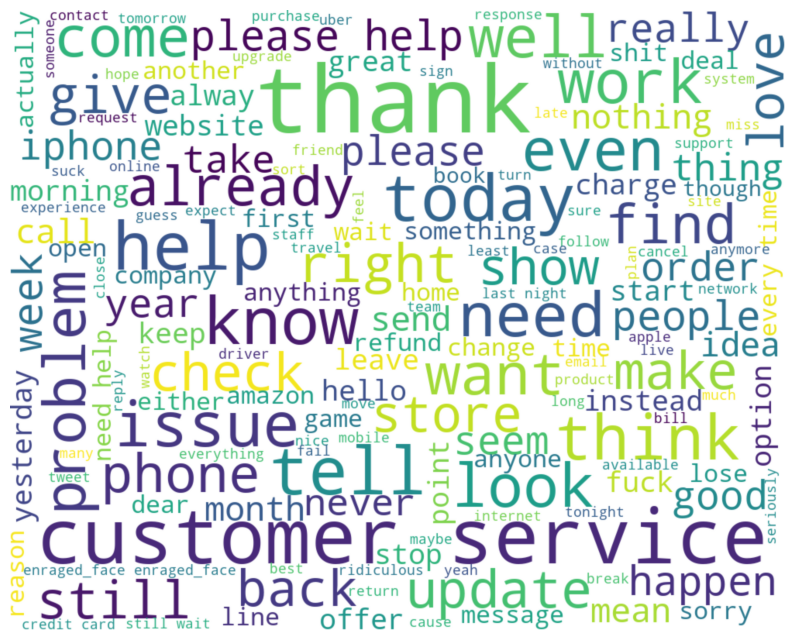

In [100]:
stopwords = set(STOPWORDS)
stopwords.add('user')

word_cloud = WordCloud(width = 1000,
                       height = 800, 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = 'white',
                       stopwords = stopwords).generate(' '.join(df['text']))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

## Empresas

In [101]:
print('Quantidade de tweets por empresa:\n')
print(print(df['empresa_id'].value_counts().sort_values(ascending=False)))

Quantidade de tweets por empresa:

empresa_id
AmazonHelp        130473
AppleSupport      115778
Uber_Support       59819
AmericanAir        43259
SpotifyCares       40925
                   ...  
PandoraSupport      1131
HiltonHelp          1105
NeweggService       1096
YahooCare           1076
BoostCare           1036
Name: count, Length: 89, dtype: int64
None


In [102]:
print('Avaliações gerais\n')
df['score'].value_counts()

Avaliações gerais



score
neutro      821233
negativo    316847
positivo    100550
Name: count, dtype: int64

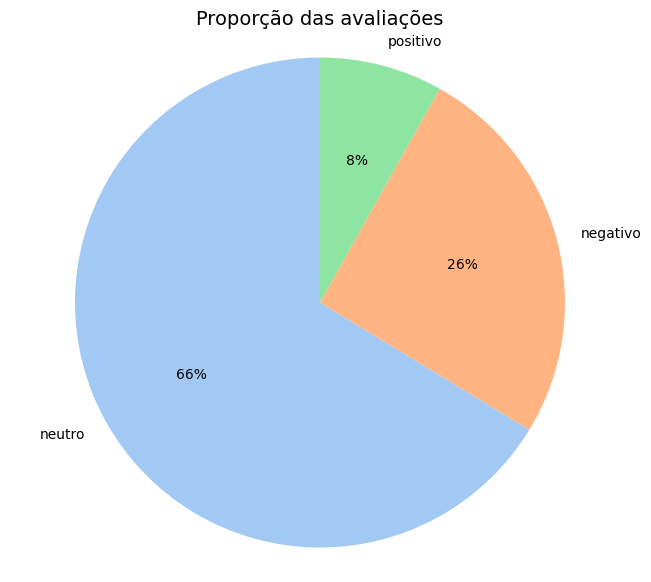

In [103]:
fig, ax = plt.subplots(figsize = (8, 7))

counts = df['score'].value_counts()
labels = counts.index.tolist()

colors = sns.color_palette('pastel')

ax.pie(counts, labels = labels, colors = colors, autopct = '%.0f%%', startangle = 90)

ax.set_title('Proporção das avaliações', fontsize = 14)

ax.axis('equal')

plt.show()

- Vamos fazer um dataset detalhando as avaliações de cada empresa. 
    - Além de ser melhor visualmente, vai facilitar a criação dos futuros gráficos.

In [104]:
# Contagem de avaliações por empresa
score_empresas = df['empresa_id'].value_counts()

# Quantidade de avaliações negativas e positivas
negativos = df[df['score'] == 'negativo']['empresa_id'].value_counts()
positivos = df[df['score'] == 'positivo']['empresa_id'].value_counts()

df_scores = pd.DataFrame({'total_avaliacoes': score_empresas,
                          'negativos': negativos, 
                          'positivos': positivos})
df_scores

,total_avaliacoes,negativos,positivos
empresa_id,,,
ATT,4798,1288,433
ATVIAssist,24275,6696,1106
AWSSupport,1230,211,137
AdobeCare,9494,2442,734
AirAsiaSupport,10789,1343,752
...,...,...,...
marksandspencer,12412,2096,2763
nationalrailenq,5174,674,388
sainsburys,18800,3695,2488


In [105]:
# Calculando as proporções
df_scores['prop_negativos'] = ((df_scores['negativos'] / df_scores['total_avaliacoes']) * 100).round(2)
df_scores['prop_positivos'] = ((df_scores['positivos'] / df_scores['total_avaliacoes']) * 100).round(2)
df_scores

,total_avaliacoes,negativos,positivos,prop_negativos,prop_positivos
empresa_id,,,,,
ATT,4798,1288,433,26.84,9.02
ATVIAssist,24275,6696,1106,27.58,4.56
AWSSupport,1230,211,137,17.15,11.14
AdobeCare,9494,2442,734,25.72,7.73
AirAsiaSupport,10789,1343,752,12.45,6.97
...,...,...,...,...,...
marksandspencer,12412,2096,2763,16.89,22.26
nationalrailenq,5174,674,388,13.03,7.50
sainsburys,18800,3695,2488,19.65,13.23


### Top 10 empresas piores e melhores avaliadas

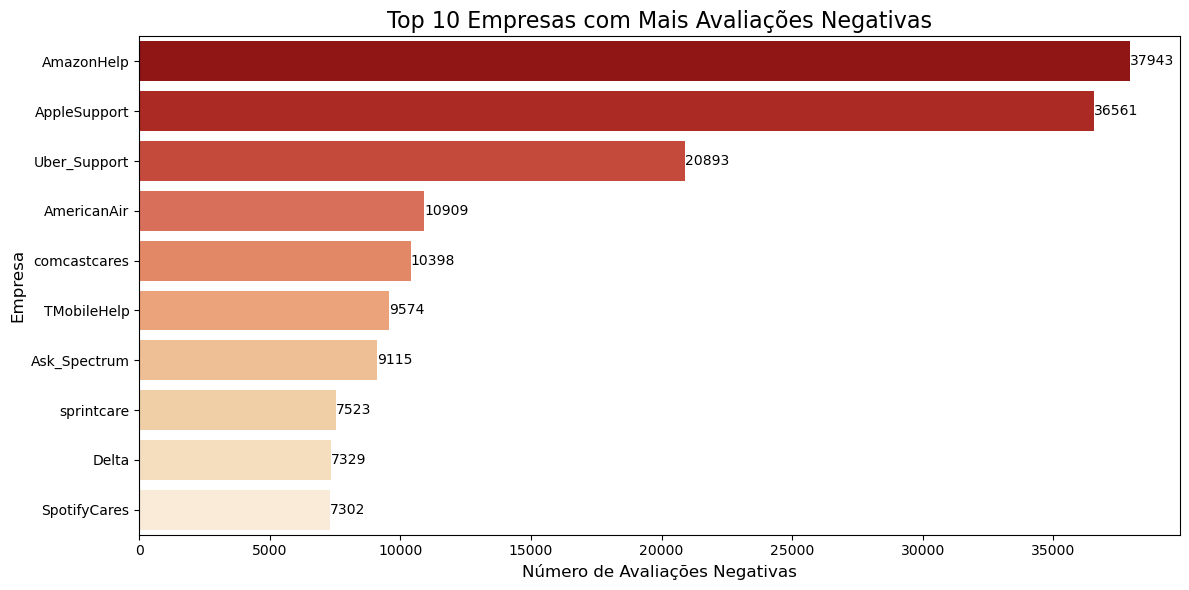

In [106]:
dez_neg = df_scores['negativos'].sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(x=dez_neg.values, 
            y=dez_neg.index, 
            hue=dez_neg.index, 
            palette='OrRd_r', 
            legend=False) 

plt.title('Top 10 Empresas com Mais Avaliações Negativas', fontsize=16)
plt.xlabel('Número de Avaliações Negativas', fontsize=12)
plt.ylabel('Empresa', fontsize=12)

for i, v in enumerate(dez_neg.values):
    plt.text(v + 3, 
             i, 
             str(v), 
             color='black', 
             va='center')

plt.tight_layout()
plt.show()

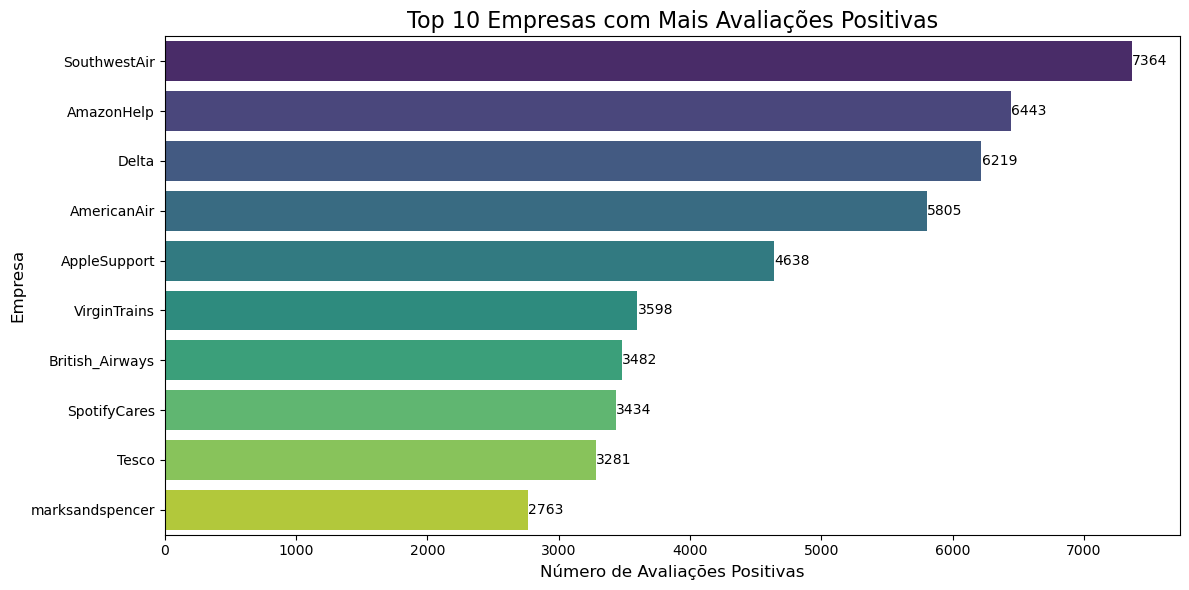

In [107]:
dez_pos = df_scores['positivos'].sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(x=dez_pos.values, 
            y=dez_pos.index, 
            hue=dez_pos.index, 
            palette='viridis', 
            legend=False)  

plt.title('Top 10 Empresas com Mais Avaliações Positivas', fontsize=16)
plt.xlabel('Número de Avaliações Positivas', fontsize=12)
plt.ylabel('Empresa', fontsize=12)

for i, v in enumerate(dez_pos.values):
    plt.text(v + 3, 
             i, 
             str(v), 
             color='black', 
             va='center')

plt.tight_layout()
plt.show()

- Olhando apenas esses dois gráficos, não podemos concluir muita coisa, afinal, empresas mundialmente conhecidas possuem um maior número de avaliações.

- Vamos refazer esses gráficos considerando a proporção.

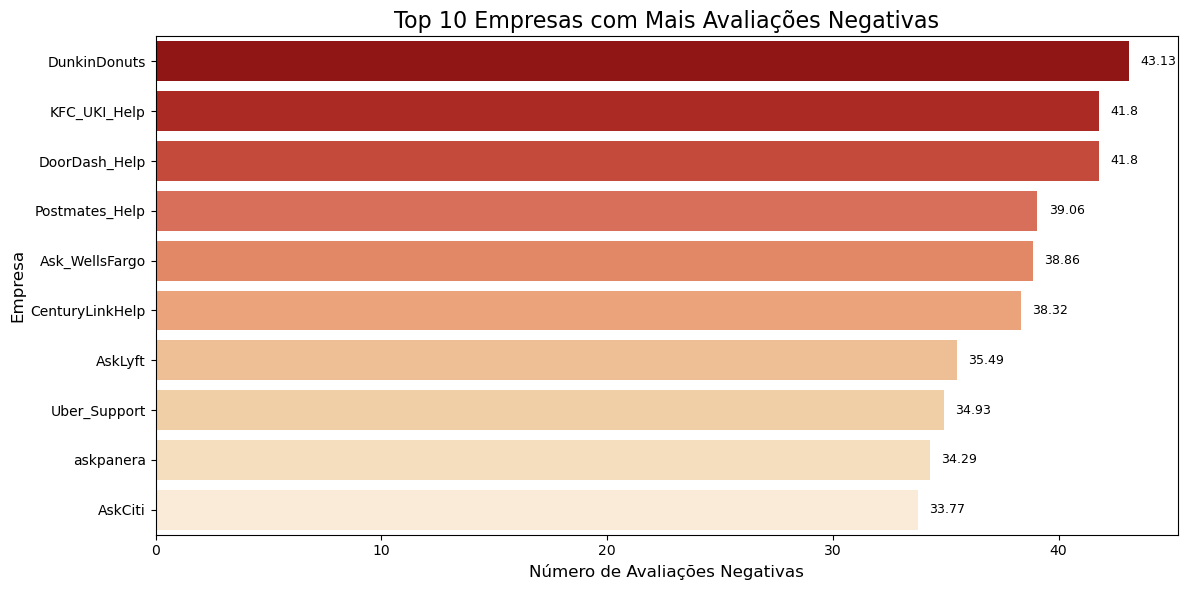

In [108]:
dez_neg = df_scores['prop_negativos'].sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(
    x=dez_neg.values,
    y=dez_neg.index,
    hue=dez_neg.index,
    palette='OrRd_r',
    legend=False
)

plt.title('Top 10 Empresas com Mais Avaliações Negativas', fontsize=16)
plt.xlabel('Número de Avaliações Negativas', fontsize=12)
plt.ylabel('Empresa', fontsize=12)

for i, v in enumerate(dez_neg.values):
    plt.text(
        v + 0.5,  
        i,
        str(v),
        color='black',
        va='center',
        fontsize=9 
    )

plt.tight_layout()
plt.show()

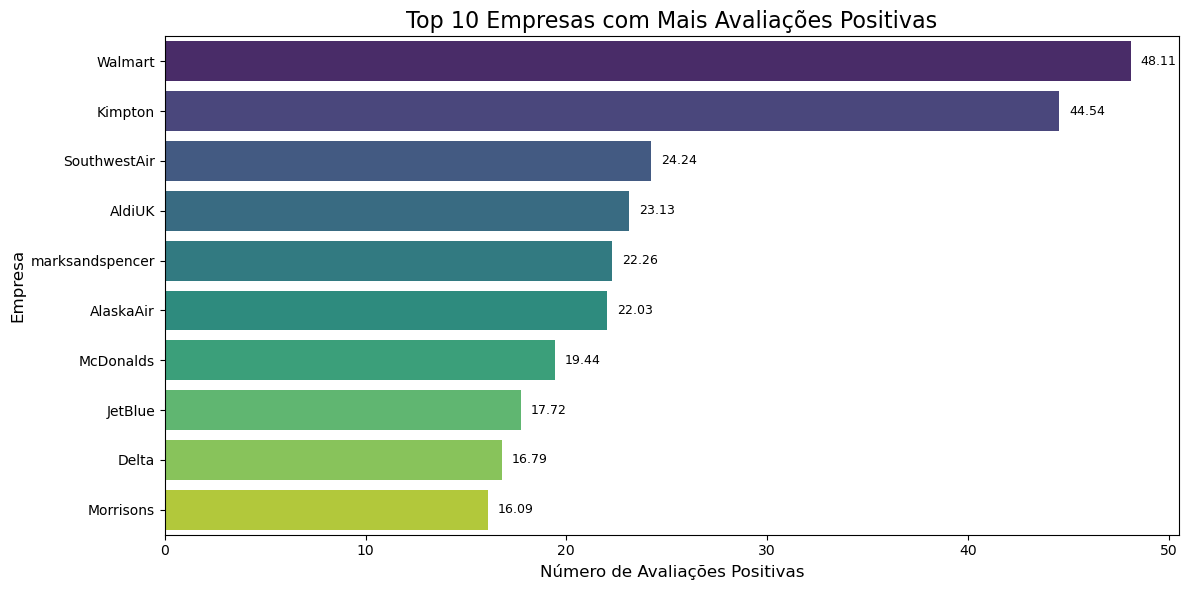

In [109]:
dez_pos = df_scores['prop_positivos'].sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(x=dez_pos.values, 
            y=dez_pos.index, 
            hue=dez_pos.index,  
            palette='viridis', 
            legend=False)  

plt.title('Top 10 Empresas com Mais Avaliações Positivas', fontsize=16)
plt.xlabel('Número de Avaliações Positivas', fontsize=12)
plt.ylabel('Empresa', fontsize=12)

for i, v in enumerate(dez_pos.values):
    plt.text(v + 0.5, 
             i, 
             str(v), 
             color='black', 
             va='center',
             fontsize=9)

plt.tight_layout()
plt.show()

- Com isso, temos dois gráficos que apresentam uma história completamente diferente dos anteriores.

    - Podemos dizer que essa nova perspectiva é mais confiável.

## Dias da semana

In [110]:
df.head()

,created_at,text,empresa_id,dia_semana,dia_mes,horario,text_original,pos_tagged,score
0,2017-10-31 22:11:45+00:00,[ user ] propose,sprintcare,Tuesday,31,22,@sprintcare and how do you propose we do that,"[([, n), (user, v), (], n), (propose, v)]",neutro
1,2017-10-31 22:08:27+00:00,[ user ] send several private message one re...,sprintcare,Tuesday,31,22,@sprintcare I have sent several private messag...,"[([, n), (user, v), (], n), (sent, v), (severa...",neutro
2,2017-10-31 21:45:10+00:00,[ user ] bad customer service,sprintcare,Tuesday,31,21,@sprintcare is the worst customer service,"[([, n), (user, a), (], n), (worst, a), (custo...",negativo
3,2017-10-31 22:04:47+00:00,[ user ] gon na magically change connectivit...,sprintcare,Tuesday,31,22,@sprintcare You gonna magically change your co...,"[([, n), (user, v), (], None), (gon, v), (na, ...",neutro
4,2017-10-31 20:00:43+00:00,[ user ] since sign you.since day,sprintcare,Tuesday,31,20,@sprintcare Since I signed up with you....Sinc...,"[([, n), (user, v), (], a), (since, None), (si...",neutro


In [111]:
dias_ordenados = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

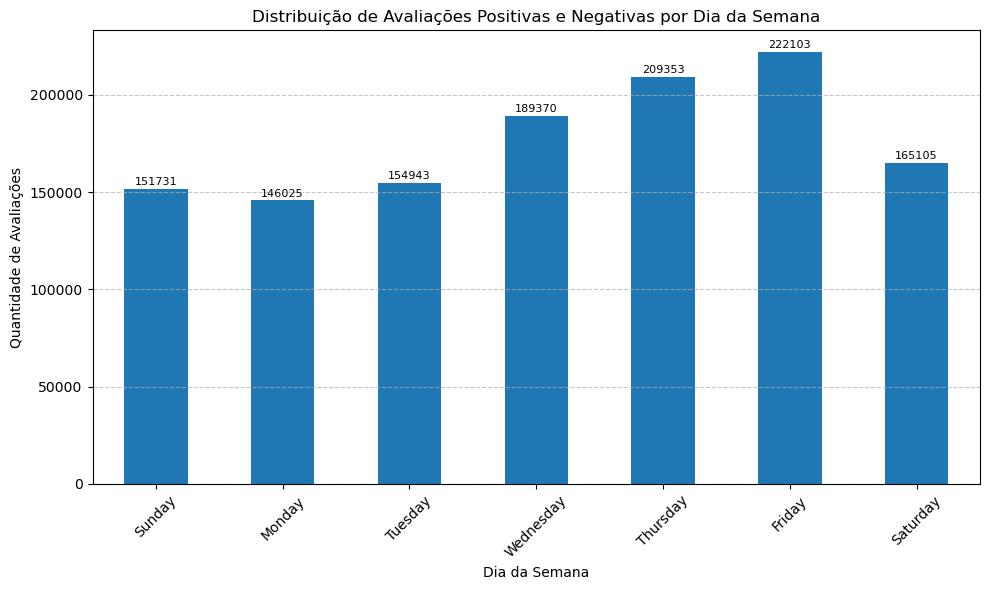

In [112]:
ax = df.value_counts('dia_semana').reindex(dias_ordenados).plot(kind='bar', figsize=(10, 6))

plt.title('Distribuição de Avaliações Positivas e Negativas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Avaliações')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height() * 1.005),
        ha='center',
        va='bottom',
        fontsize=8,
    )

plt.tight_layout()
plt.show()

- De sexta para sábado, há uma queda repentina no volume de avaliações.
- Entre sábado e terça, observamos o menor número de avaliações.
  - Indicando que os usuários estão menos propensos a avaliar durante o fim de semana e o começo da semana.
- De quarta a sexta, o volume de avaliações aumenta. 

In [113]:
# Agrupando e fanzendo a contagem dos dados por dia_semana e score
df_grouped = df.groupby(['dia_semana', 'score']).size().unstack(fill_value=0)
df_grouped = df_grouped.reindex(dias_ordenados)
df_grouped

score,negativo,neutro,positivo
dia_semana,,,
Sunday,39771,100346,11614
Monday,37024,97717,11284
Tuesday,39800,102854,12289
Wednesday,47801,125960,15609
Thursday,52296,139031,18026
Friday,56369,147130,18604
Saturday,43786,108195,13124


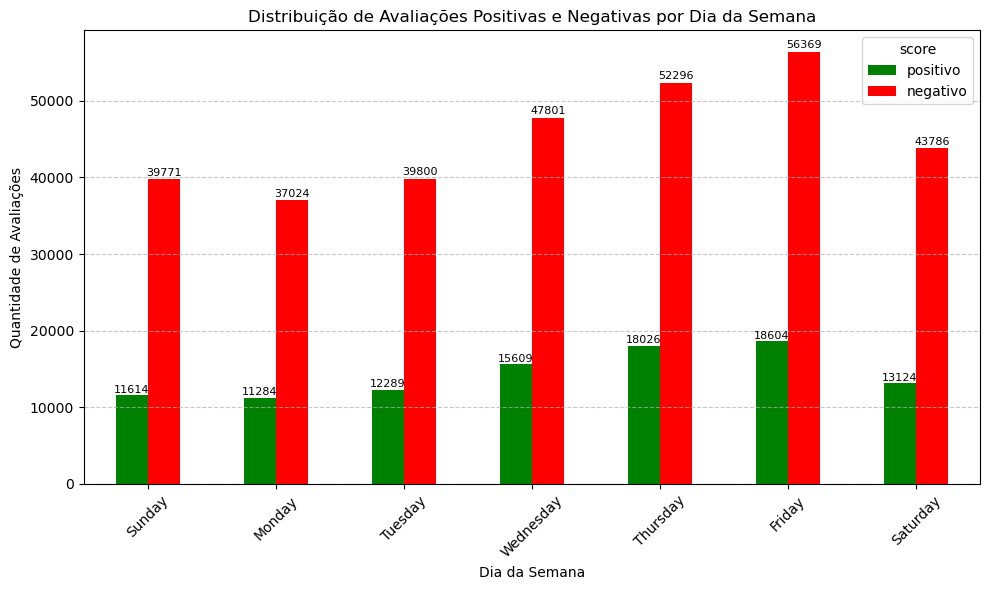

In [114]:
ax = df_grouped[['positivo', 'negativo']].plot(kind='bar', figsize=(10, 6), color=['green', 'red'])

plt.title('Distribuição de Avaliações Positivas e Negativas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Avaliações')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height() * 1.005),
        ha='center',
        va='bottom',
        fontsize=8,
    )

plt.tight_layout()
plt.show()

In [115]:
df_grouped.head()

score,negativo,neutro,positivo
dia_semana,,,
Sunday,39771,100346,11614
Monday,37024,97717,11284
Tuesday,39800,102854,12289
Wednesday,47801,125960,15609
Thursday,52296,139031,18026


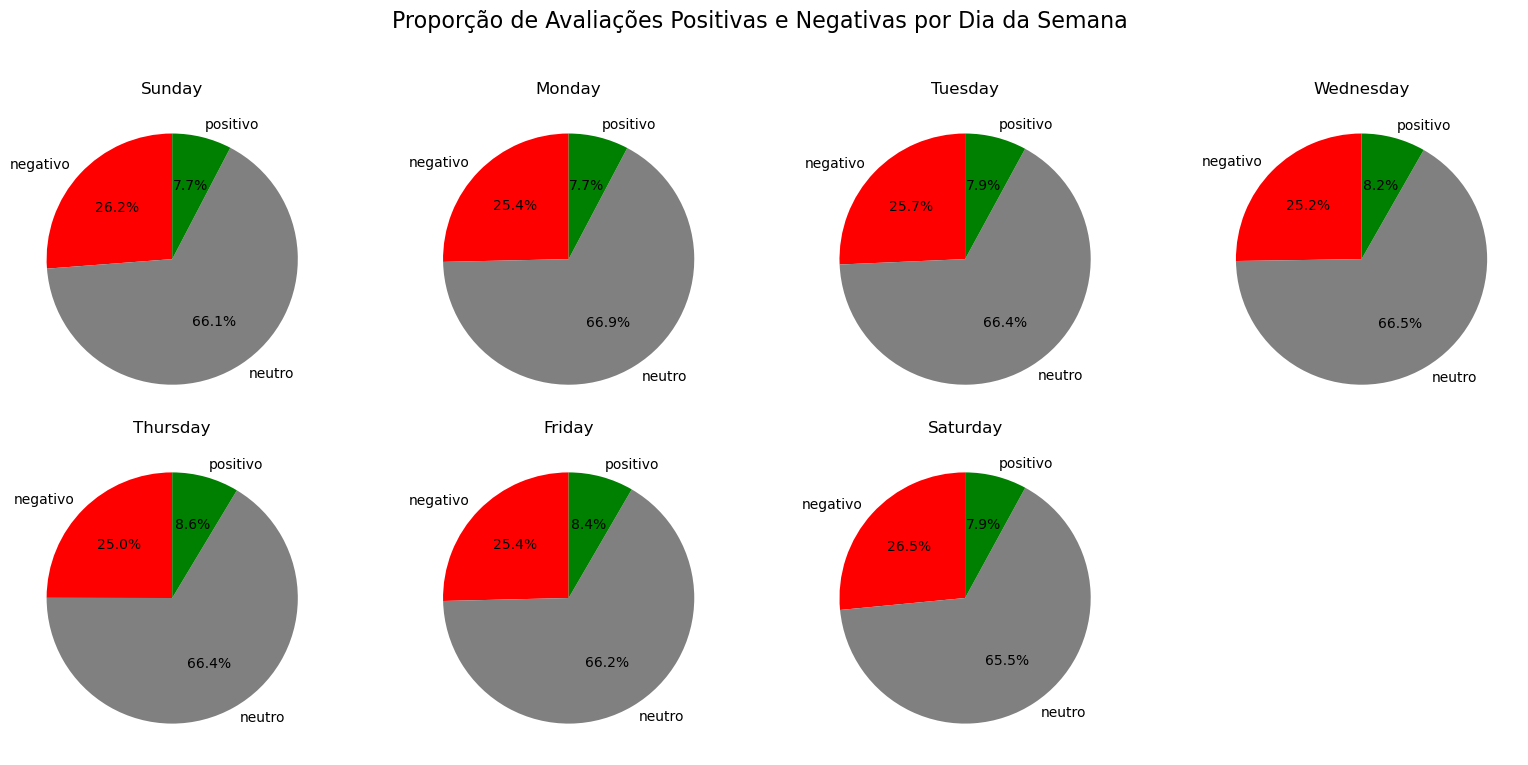

In [116]:
# Definnindo as cores
cores = ['red', 'grey', 'green']

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

# Itera sobre cada dia da semana
for i, dia in enumerate(df_grouped.index):
    valores = df_grouped.loc[dia]
    axs[i].pie(
        valores,
        labels=valores.index,
        autopct='%1.1f%%',
        colors=cores,
        startangle=90
    )
    axs[i].set_title(f'{dia}')

# Remove o subplot extra
fig.delaxes(axs[-1])

plt.suptitle('Proporção de Avaliações Positivas e Negativas por Dia da Semana', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- A proporção entre avaliações positivas e negativas é semelhante, o que demonstra uma consistência ao longo da semana.
- Ou seja, o dia da semana influencia mais o volume de avaliações do que na avaliação em sí.

# Dias do mês

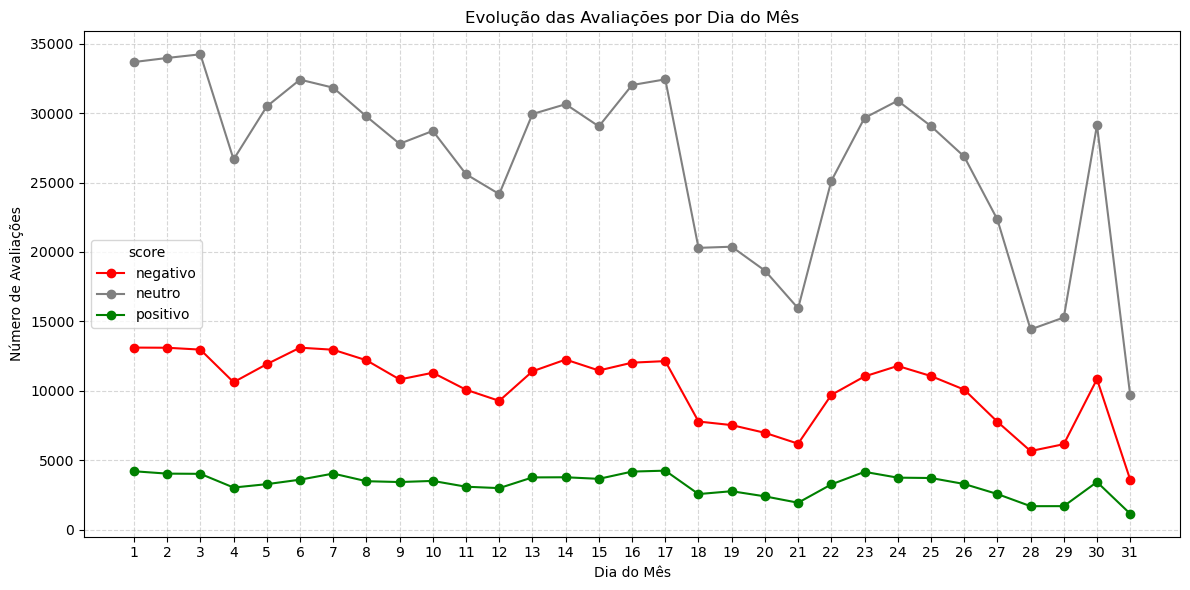

In [117]:
avaliacoes_por_dia = df.groupby(['dia_mes', 'score']).size().unstack(fill_value=0)
avaliacoes_por_dia = avaliacoes_por_dia.sort_index()

avaliacoes_por_dia.plot(figsize=(12, 6), marker='o', color=['red', 'grey', 'green'])
plt.title('Evolução das Avaliações por Dia do Mês')
plt.xlabel('Dia do Mês')
plt.ylabel('Número de Avaliações')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, 32))
plt.tight_layout()
plt.show()


- As avaliações neutras seguem um padrão muito semelhante ao das negativas, só que em proporções maiores. 
- Acredito que as avaliações neutras não possuem informações muito relevantes, então irei excluí-las.

In [118]:
avaliacoes_por_dia.drop('neutro', axis=1, inplace=True)

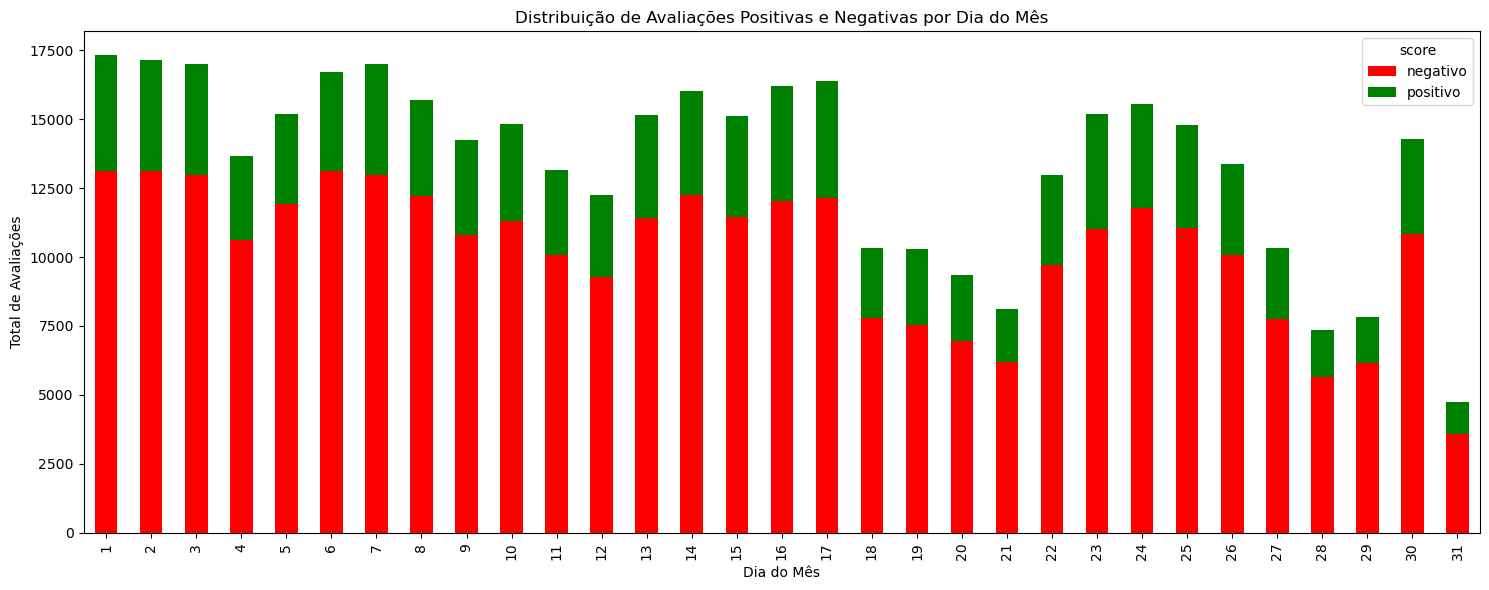

In [119]:
avaliacoes_por_dia.plot(kind='bar', stacked=True, figsize=(15, 6), color=['red', 'green'])
plt.title('Distribuição de Avaliações Positivas e Negativas por Dia do Mês')
plt.xlabel('Dia do Mês')
plt.ylabel('Total de Avaliações')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Embora o gráfico separe as avaliações positivas das negativas, ele não ajudou a tirar muitas conclusões entre os dois tipos de sentimento.
- Porém mostrou os dias com maior ou menor volume de avaliações.
  - É possível ver dois intervalos onde o número de avaliações é menor: do dia 18 ao 21, e do dia 27 a 29.
  - O dia 31 apresenta o menor volume, o que era esperado, pois não ocorre em todos os meses.

- Agora, vamos levar em consideração as proporções.
- Em vez de criar um gráfico de pizza para cada dia (o que resultaria em 31 gráficos), vamos fazer um gráfico de barras com a proporção líquida das avaliações.

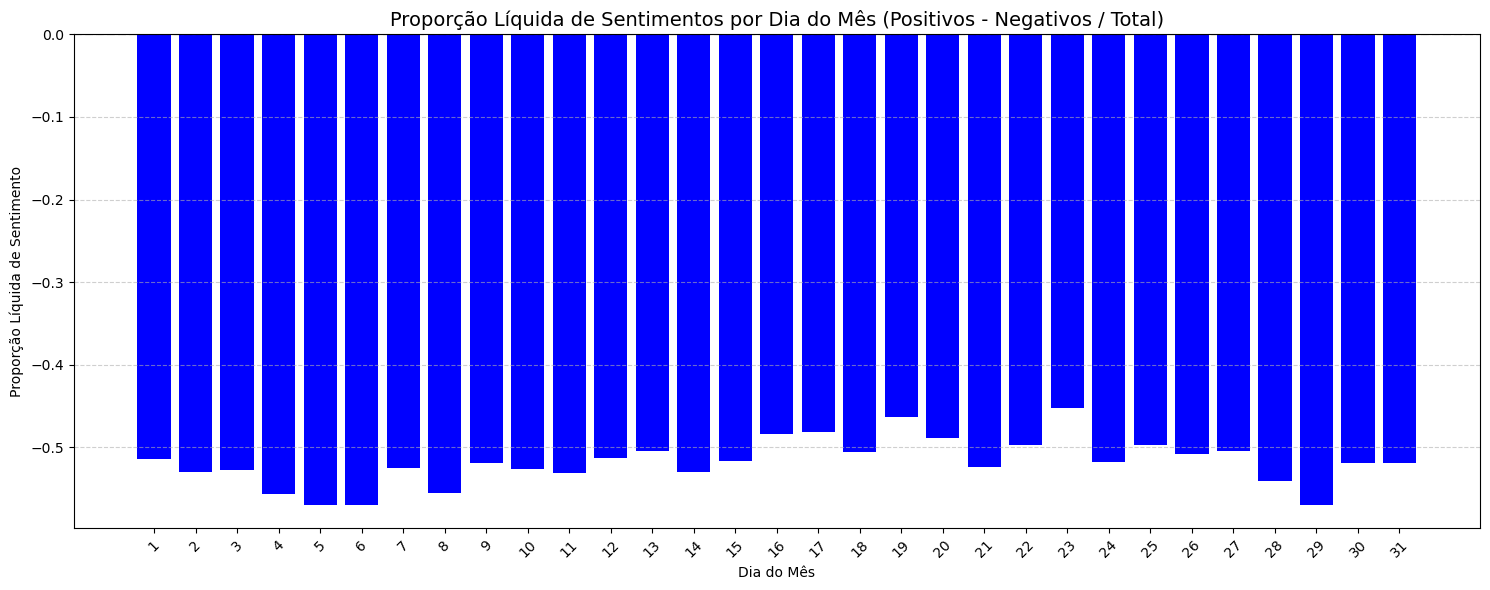

In [120]:
avaliacoes_por_dia['total'] = avaliacoes_por_dia.sum(axis=1)
avaliacoes_por_dia['proporcao_liquida'] = (avaliacoes_por_dia['positivo'] - avaliacoes_por_dia['negativo']) / avaliacoes_por_dia['total']

plt.figure(figsize=(15, 6))
plt.bar(avaliacoes_por_dia.index.astype(str), avaliacoes_por_dia['proporcao_liquida'], color='blue')
plt.axhline(0, color='black', linestyle='--')

plt.title('Proporção Líquida de Sentimentos por Dia do Mês (Positivos - Negativos / Total)', fontsize=14)
plt.xlabel('Dia do Mês')
plt.ylabel('Proporção Líquida de Sentimento')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- É possível notar algumas nuances, mas achei esse gráfico pouco conclusivo.
- Vamos acrescentar uma média móvel para suavizar as variações e facilitar a interpretação dos dados.

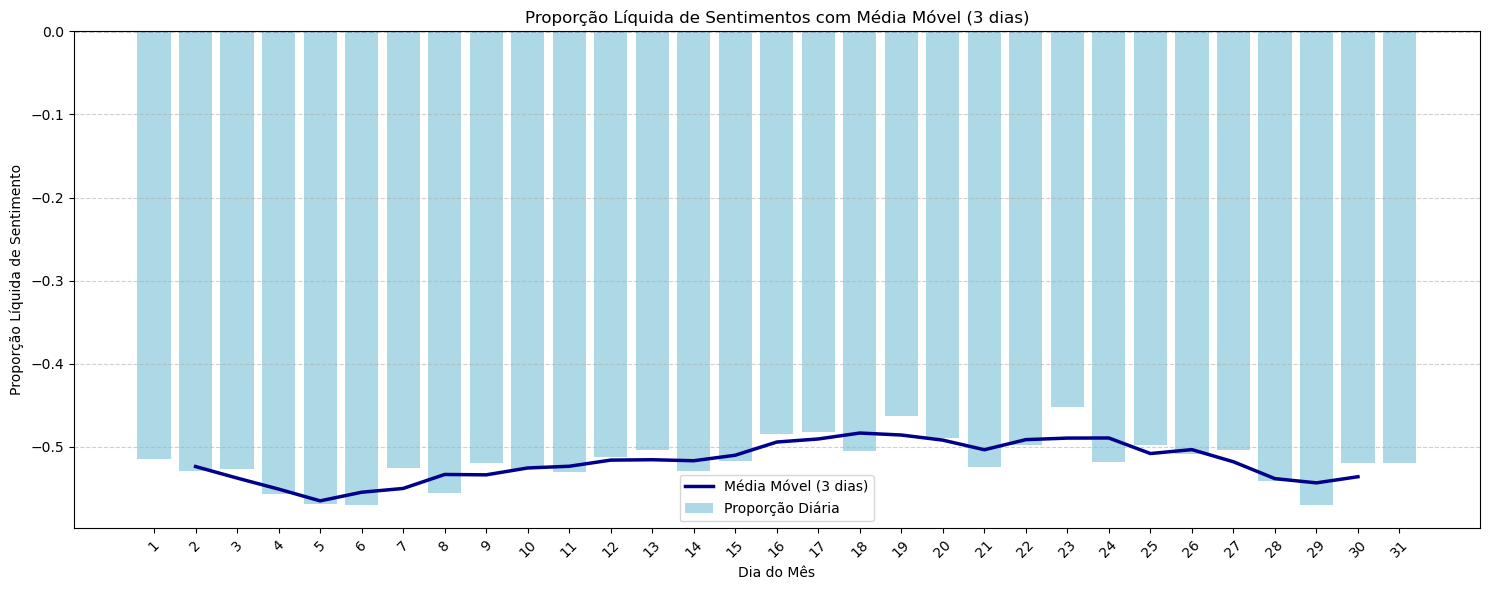

In [121]:
# Média móvel
avaliacoes_por_dia['media_movel'] = avaliacoes_por_dia['proporcao_liquida'].rolling(window=3, center=True).mean()

plt.figure(figsize=(15, 6))

plt.bar(avaliacoes_por_dia.index.astype(str), avaliacoes_por_dia['proporcao_liquida'], color='lightblue', label='Proporção Diária')

# Linha da média móvel
plt.plot(avaliacoes_por_dia.index.astype(str), avaliacoes_por_dia['media_movel'], color='darkblue', linewidth=2.5, label='Média Móvel (3 dias)')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Proporção Líquida de Sentimentos com Média Móvel (3 dias)')
plt.xlabel('Dia do Mês')
plt.ylabel('Proporção Líquida de Sentimento')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


- A proporção líquida atinge o ponto mais negativo entre os dias 4 e 6, sugerindo uma predominância de sentimentos negativos.
- Após o sexto dia, se tem uma melhora nas avaliações, que permanece até o fim do mês. No entanto, entre os dias 26 e 29, há uma nova queda nas avaliações.

Obs: Esse gráfico não considera os feriados e os dias da semana.

# Horários

In [122]:
avaliacoes_por_hora = df.groupby(['horario', 'score']).size().unstack(fill_value=0)
avaliacoes_por_hora = avaliacoes_por_hora.sort_index()
avaliacoes_por_hora


score,negativo,neutro,positivo
horario,,,
0,13616,33597,4025
1,13320,31686,3873
2,12388,28694,3425
3,10969,25954,2999
4,9830,22594,2497
5,8714,20371,2155
6,8354,20412,2062
7,8961,22897,2316
8,8772,24158,2610


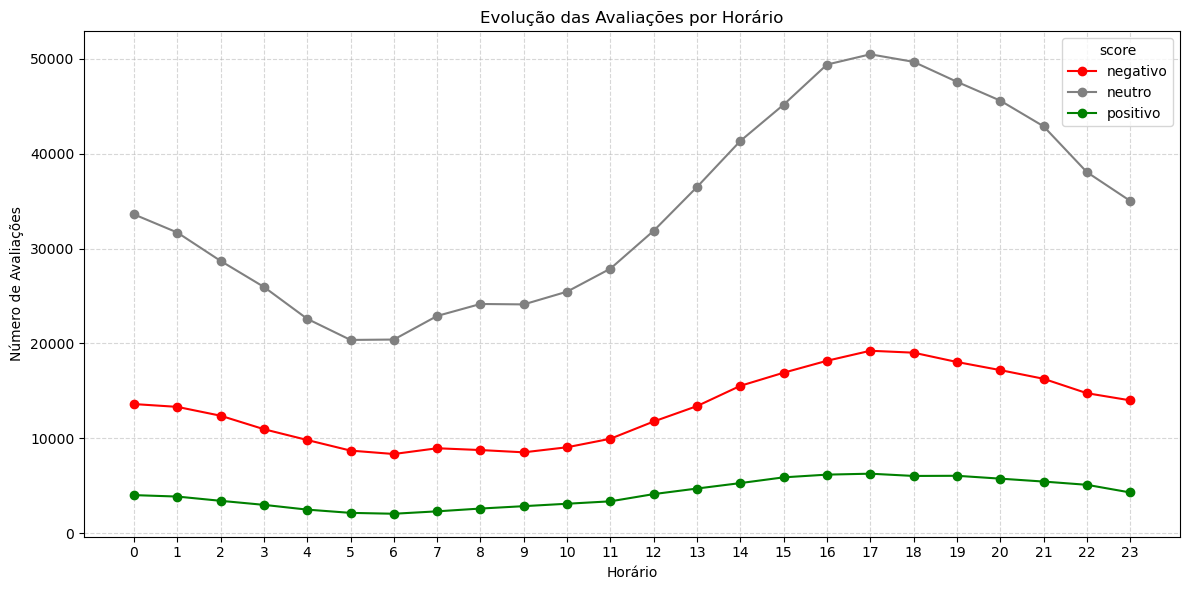

In [123]:
avaliacoes_por_hora.plot(figsize=(12, 6), marker='o', color=['red', 'grey', 'green'])
plt.title('Evolução das Avaliações por Horário')
plt.xlabel('Horário')
plt.ylabel('Número de Avaliações')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [124]:
avaliacoes_por_hora.drop('neutro', axis=1, inplace=True)

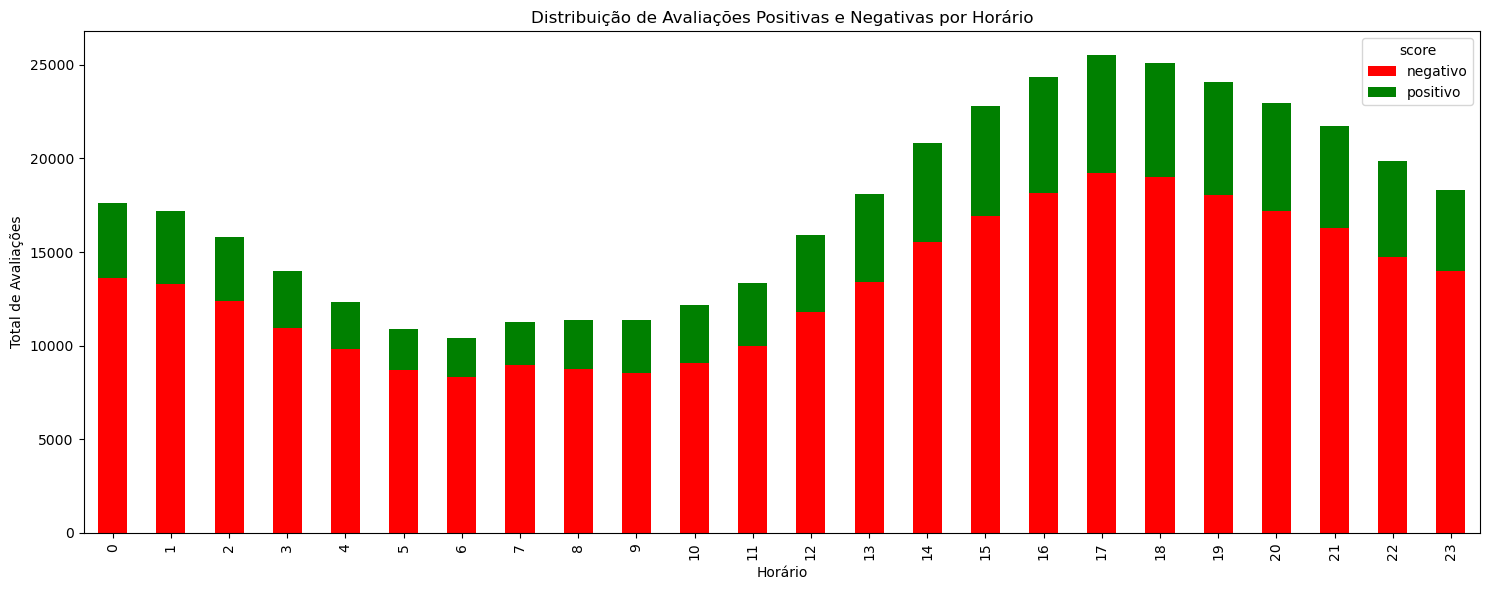

In [125]:
avaliacoes_por_hora.plot(kind='bar', stacked=True, figsize=(15, 6), color=['red', 'green'])
plt.title('Distribuição de Avaliações Positivas e Negativas por Horário')
plt.xlabel('Horário')
plt.ylabel('Total de Avaliações')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Novamente, esse gráfico não ajudou a tirar muitas conclusões entre os dois tipos de sentimento.
- Podemos perceber que durante a madrugada (0h às 4h) o volume de avaliações começa a cair.
  - Curiosamente, ao final da madrugada (4h), tem um leve aumento no volume, superando os horários seguintes (5h a 9h).
- A partir das 10 da manhã, temos uma crescente até chegar ao pico às 17h (5 da tarde), momento em que começa a cair novamente.

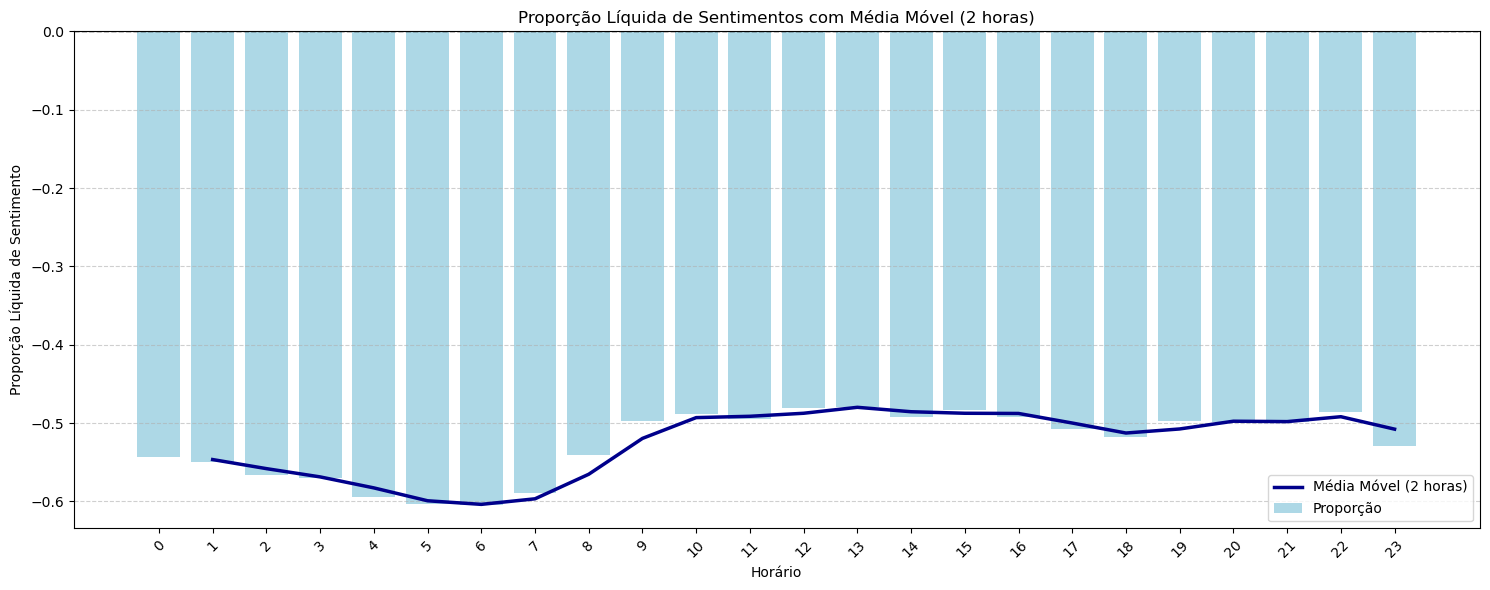

In [126]:
avaliacoes_por_hora['total'] = avaliacoes_por_hora.sum(axis=1)
avaliacoes_por_hora['proporcao_liquida'] = (avaliacoes_por_hora['positivo'] - avaliacoes_por_hora['negativo']) / avaliacoes_por_hora['total']

# Média móvel
avaliacoes_por_hora['media_movel'] = avaliacoes_por_hora['proporcao_liquida'].rolling(window=2, center=True).mean()

plt.figure(figsize=(15, 6))

plt.bar(avaliacoes_por_hora.index.astype(str), avaliacoes_por_hora['proporcao_liquida'], color='lightblue', label='Proporção')

# Linha da média móvel
plt.plot(avaliacoes_por_hora.index.astype(str), avaliacoes_por_hora['media_movel'], color='darkblue', linewidth=2.5, label='Média Móvel (2 horas)')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Proporção Líquida de Sentimentos com Média Móvel (2 horas)')
plt.xlabel('Horário')
plt.ylabel('Proporção Líquida de Sentimento')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

- O gráfico mostra que durante a madrugada e o início da manhã (entre 0h e 7h), a proporção líquida de sentimentos é mais negativa, atingindo seu ponto mais baixo por volta das 4h e 6h. 
- A partir das 7h da manhã, observamos uma melhora gradual nos sentimentos, se tornando menos negativa ao longo da manhã e início da tarde.
- O melhor momento do dia ocorre ás 13h.
- Após esse pico, há uma leve piora até às 18h, onde demonstra uma leve melhora até às 22h.

In [127]:
# Proporças das avaliações positivas por horário
avaliacoes_por_hora['prop_positivo'] = ((avaliacoes_por_hora['positivo'] / avaliacoes_por_hora['total'])*100).round(2)

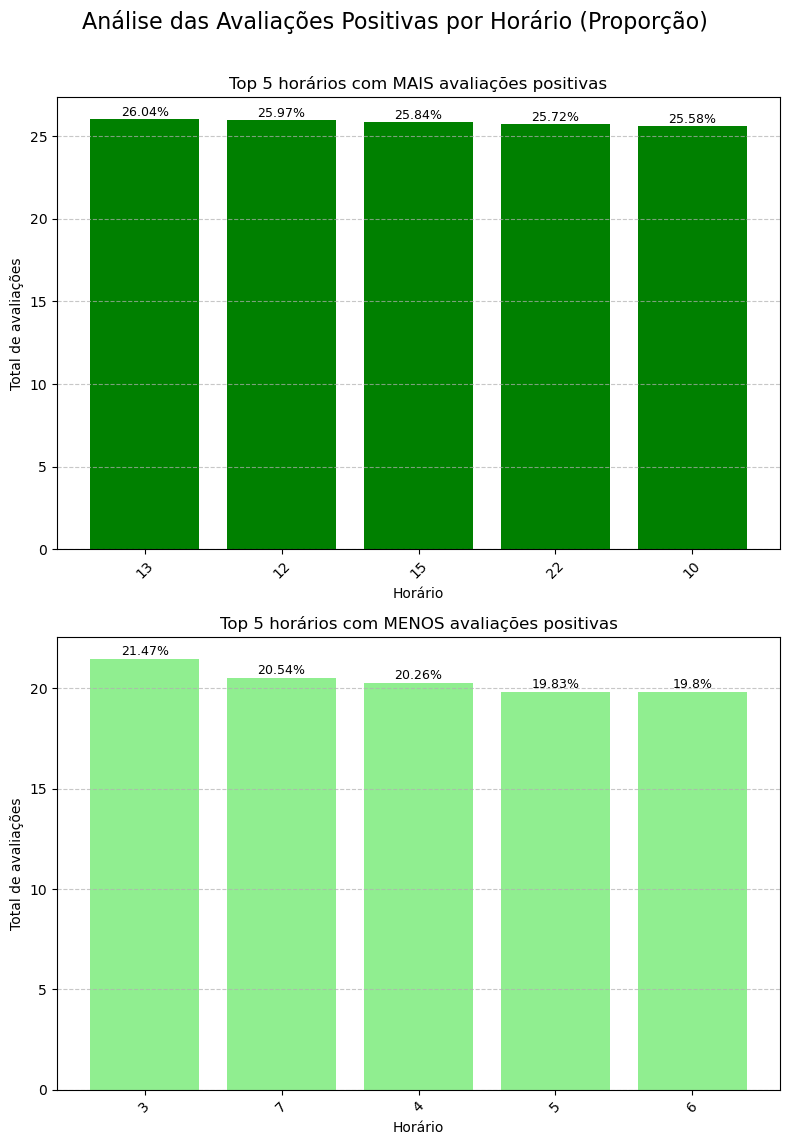

In [128]:
top_5_mais_pos = avaliacoes_por_hora['prop_positivo'].sort_values(ascending=False).head(5)
top_5_menos_pos = avaliacoes_por_hora['prop_positivo'].sort_values(ascending=False).tail(5)

fig, axs = plt.subplots(2, 1, figsize=(8, 12))
axs = axs.flatten() 

# Top 5 MAIS positivas
axs[0].bar(top_5_mais_pos.index.astype(str), top_5_mais_pos, color='green')
axs[0].set_title('Top 5 horários com MAIS avaliações positivas')
axs[0].set_xlabel('Horário')
axs[0].set_ylabel('Total de avaliações')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(top_5_mais_pos):
    axs[0].text(i, v + 0.2, f'{v}%', ha='center', fontsize=9)

# Top 5 MENOS positivas
axs[1].bar(top_5_menos_pos.index.astype(str), top_5_menos_pos, color='lightgreen')
axs[1].set_title('Top 5 horários com MENOS avaliações positivas')
axs[1].set_xlabel('Horário')
axs[1].set_ylabel('Total de avaliações')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(top_5_menos_pos):
    axs[1].text(i, v + 0.2, f'{v}%', ha='center', fontsize=9)

plt.suptitle('Análise das Avaliações Positivas por Horário (Proporção)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


- A diferença entre o melhor e o pior horário é de apenas 6,26%. Mostrando que não existe uma diferença significativa entre os horários individualmente. 